# Initializations

In [1]:
import ringdown
from ringdb import Database
import json
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

import json
import os

from scripts.Posterior import Posterior, ChargedPosterior
from PIL import Image
import glob
 
    
def create_anim(filename, folder="./temp", duration=500):
    # Create the frames
    frames = []
    imgs = glob.glob(f"{folder}/*.png")
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(f'{filename}.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=500, loop=0)


# Set up database
data_folder = "./Data" # Folder where the downloaded strain data is saved
alternative_data_folder = "./AlternativeData" # Folder where the strain is saved

db = Database(data_folder)
db.initialize()

db.update_posterior_schema({'f_low': {'path': "/{approximant}/meta_data/meta_data/f_low", 'type':'value'}})
db.update_posterior_schema({'f_ref': {'path': "/{approximant}/meta_data/meta_data/f_ref", 'type':'value'}})

class Tasks:
    def __init__(self, tasks, folder):
        self.folder = folder
        self.tasks = tasks
        
    @classmethod
    def from_folder(cls, foldername):
        with open(f'{foldername}/tasks_json','r') as f:
            imported_task_file = json.load(f)
            
        for task in imported_task_file:
            fitt = ringdown.Fit.from_config(task['config'].replace("./",f"{foldername}/"))
            try:
                fitt.result = az.from_netcdf(task['output_file'].replace("./",f"{foldername}/"))
            except FileNotFoundError:
                pass
            task["fit"] = fitt
            
        return cls(imported_task_file, foldername)
    
    def create_task_dir(self, masterfolder="."):
        script_masterfolder = self.folder
        tasks = self.tasks
        
        if not os.path.exists(self.folder):
            os.mkdir(self.folder)

        binary_file = f"{script_masterfolder}/ringdown_fit"
        if not os.path.exists(binary_file):
            binary_file_url = "https://raw.githubusercontent.com/Potatoasad/ringdown/main/bin/ringdown_fit"
            urllib.request.urlretrieve(binary_file_url, binary_file)


        for task in tasks:
            run_folder = f"{masterfolder}/{task['name']}"
            script_run_folder = f"{script_masterfolder}/{task['name']}"
            task["folder"] = run_folder
            os.makedirs(script_run_folder, exist_ok = True)

            run_config = f"{masterfolder}/{task['name']}/{task['name']}.cfg"
            script_run_config = f"{script_masterfolder}/{task['name']}/{task['name']}.cfg"
            task["config"] = run_config
            task["fit"].to_config(script_run_config)

            task["output_file"] = run_config.replace(".cfg", "-output.nc")

            task["run_command"] = f"""python {masterfolder}/ringdown_fit {run_config} -o {task["output_file"]}"""

        self.tasks = tasks
        if os.path.exists(f'{script_masterfolder}/taskfile'):
            os.remove(f'{script_masterfolder}/taskfile')

        for task in tasks:
            with open(f'{script_masterfolder}/taskfile', 'a') as taskfile:
                taskfile.write(task["run_command"] + "\n")

        with open(f'{script_masterfolder}/tasks_json','w') as tasks_json:
            json.dump([{k:v for k,v in task.items() if k not in ["fit"]} for task in tasks],
                     tasks_json)
            

def get_Posterior(task):
    if 'q' not in task["model"]:
        test_cf = Posterior(task["eventname"], inference_data=task["fit"].result) # Use Posterior if uncharged analysis
    else:
        test_cf = ChargedPosterior(task["eventname"], inference_data=task["fit"].result) # Use Charged Posterior if uncharged analysis
    return test_cf

from PIL import Image
import glob
 
    
def create_anim(filename, folder="./temp", duration=800):
    # Create the frames
    frames = []
    imgs = glob.glob(f"{folder}/*.png")
    imgs.sort()
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(f'{filename}.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=duration, loop=0)
    
    return imgs

# Getting results from a task

In [2]:
ts = Tasks.from_folder("./GW150914-StartTimeSweep")

In [3]:
# Hack to order the tasks
df = pd.DataFrame(ts.tasks)
df.sort_values('name', inplace=True)
ts.tasks = [a.to_dict() for i,a in df.iterrows()]

In [4]:
ts.tasks

[{'name': 'mchi-GW150914-0--2-geocent-shift',
  'eventname': 'GW150914',
  'model': 'mchi',
  'modes': [[1, -2, 2, 2, 0], [1, -2, 2, 2, 1]],
  'target': {'t0': 1126259462.4093595,
   'ra': 1.7744888175831761,
   'dec': -1.265526425854647,
   'psi': 1.8213703067210636},
  'H1_peak': 1126259462.4232538,
  'L1_peak': 1126259462.4162014,
  'geocent_peak': 1126259462.4093595,
  'mass_for_prior': 67.21379165732674,
  'duration': 0.1,
  'target_sample_rate': 4096,
  'cond_kws': {'flow': 20.0},
  'folder': './mchi-GW150914-0--2-geocent-shift',
  'config': './mchi-GW150914-0--2-geocent-shift/mchi-GW150914-0--2-geocent-shift.cfg',
  'output_file': './mchi-GW150914-0--2-geocent-shift/mchi-GW150914-0--2-geocent-shift-output.nc',
  'run_command': 'python ./ringdown_fit ./mchi-GW150914-0--2-geocent-shift/mchi-GW150914-0--2-geocent-shift.cfg -o ./mchi-GW150914-0--2-geocent-shift/mchi-GW150914-0--2-geocent-shift-output.nc',
  'fit': <ringdown.fit.Fit at 0x7ff0691a8970>},
 {'name': 'mchi-GW150914-1--1-

# Sanity check all chains

In the cell below change `i` to go through the posteriors and trace plots in each case. Experiment with removing different chains and finalize the list of bad chains for each index. 

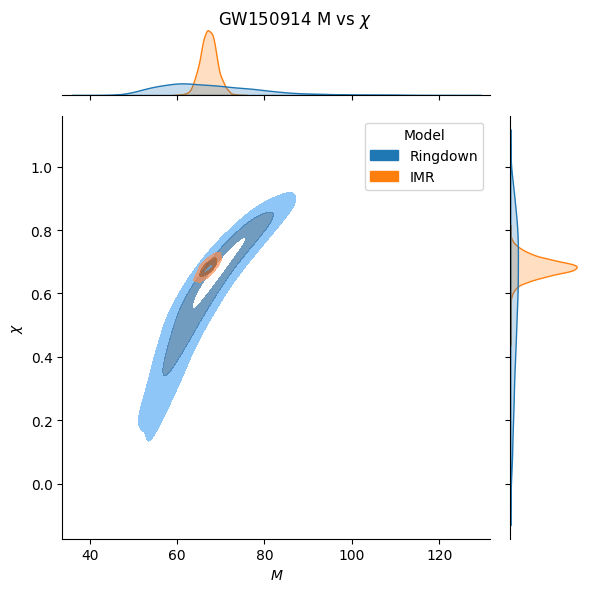

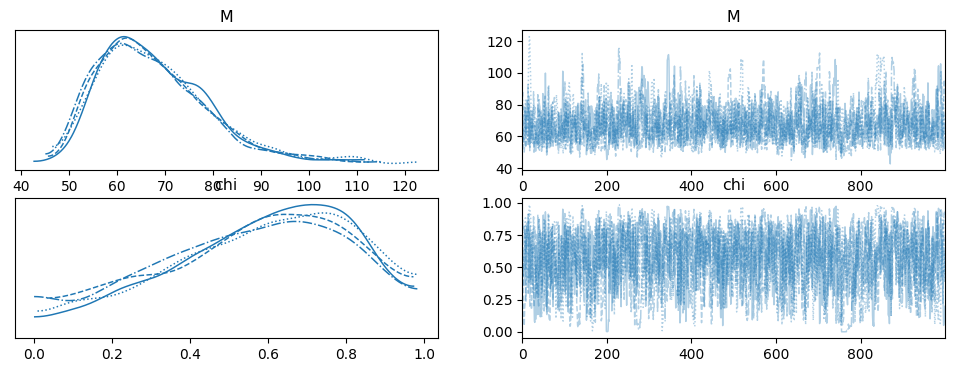

In [10]:
i = 5 # Scroll through this and look at the chains
event = db.event(ts.tasks[i]["eventname"])
posts = event.posteriors()
P = get_Posterior(ts.tasks[i])
P.remove_bad_chains([])       #change the list of chains e.g. [] -> [0,1] 
P.M_chi_plot(IMR=posts)
P.plot_trace(var_names=['M','chi'])
# Running list of bad chains [[2],[],[],[],[]]

# M vs chi Animation

In [14]:
temp_folder = "./temp"
gif_name = "starttimesweep"

(not os.path.exists(temp_folder)) and os.mkdir(temp_folder)

M_IMR_alias='final_mass'; chi_IMR_alias='final_spin'
ringdown_colnames = [(r'$M$','M'), (r'$\chi$','chi')]
IMR_colnames = [(r'$M$',M_IMR_alias), (r'$\chi$',chi_IMR_alias)]

bad_chains = [[],[],[],[],[],[],[],[]]

for i,task in enumerate(ts.tasks):
    P = get_Posterior(ts.tasks[i])
    print(ts.tasks[i]["name"], ts.tasks[i]["target"]["t0"])
    # Remove the bad chains for particular entries
    P.remove_bad_chains(bad_chains[i])
    
    # Grab the posteriors
    event = db.event(ts.tasks[i]["eventname"])
    posts = event.posteriors()
    t0 = ts.tasks[i]["target"]["t0"]
    title = f"GW150914 start time {i-2} t_M"
    
    # M vs chi dataframe
    M_chi = P.combined_results(IMR=posts, ringdown_colnames=ringdown_colnames, IMR_colnames=IMR_colnames)
    
    # Plot it with fixed limits
    g = sns.jointplot(data=M_chi, x=r'$M$', y=r'$\chi$', hue='Model',
              kind='kde', fill=True, levels=[0.3,0.6,0.9],common_norm=False, alpha=0.7,
              xlim=[ts.tasks[0]["fit"].prior_settings['M_min'],
                   ts.tasks[0]["fit"].prior_settings['M_max']],
             ylim=[0,1]);
    
    g.fig.suptitle(title)
    
    # Save the frame
    g.fig.savefig(f"{temp_folder}/{i}.png");
    plt.close(g.fig)

# Create the animation
imgs = create_anim(gif_name.replace(".gif",""))
os.system(f"rm -rf {temp_folder}")

mchi-GW150914-0--2-geocent-shift 1126259462.4093595
mchi-GW150914-1--1-geocent-shift 1126259462.4096954
mchi-GW150914-2-0-geocent-shift 1126259462.410031
mchi-GW150914-3-1-geocent-shift 1126259462.4103668
mchi-GW150914-4-2-geocent-shift 1126259462.4107027
mchi-GW150914-5-3-geocent-shift 1126259462.4110384


0

![](./geocent-sweep.gif)

# fs vs tau-s animation

#### Compute the f and tau samples from the IMR posteriors. 

In [ ]:
import qnm
import lal
import numpy as np
T_MSUN = lal.MSUN_SI * lal.G_SI / lal.C_SI**3
q220 = qnm.modes_cache(-2, 2, 2, 0)
q221 = qnm.modes_cache(-2,2,2,1)

def get_fgamma(M, chi, n, l=2, m=2):
    if n == 0:
        omega, _, _ = q220(a=chi)
    else:
        omega, _, _ = q221(a=chi)
    f = np.real(omega)/(2* np.pi) / (T_MSUN*M)
    gamma = abs(np.imag(omega)) / (T_MSUN*M)
    return f, gamma

mode1 = lambda M,chi: {'$f$': get_fgamma(M,chi,0)[0], '$\gamma$': get_fgamma(M,chi,0)[1], 
               'mode': "220-IMR", 'Model': "ringdown"}

mode2 = lambda M,chi: {'$f$': get_fgamma(M,chi,1)[0], '$\gamma$': get_fgamma(M,chi,1)[1], 
               'mode': "221-IMR", 'Model': "ringdown"}

posts = event.posteriors()[["final_mass","final_spin"]].sample(4000)


final_posts = []
j = 0
for i,x in posts.iterrows():
    print(j); j = j + 1;
    final_posts.append(mode1(x["final_mass"],x["final_spin"]))
    final_posts.append(mode2(x["final_mass"],x["final_spin"]))

final_posts_f_gamma = pd.DataFrame(final_posts)

#### f_tau comparison Plotting function

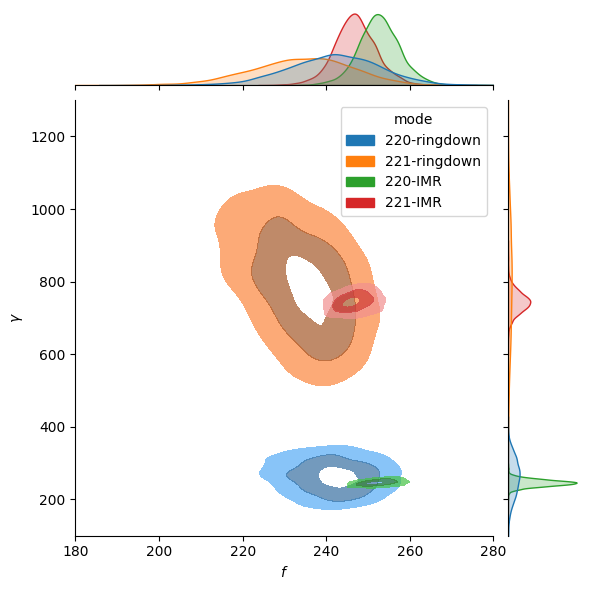

In [70]:
def f_tau_comparison_plot(result, IMR_f_gamma, xlim=[180,280], ylim=[100,1300]):
    f0 = result.posterior.f.values[:,:,0].flatten()
    f1 = result.posterior.f.values[:,:,1].flatten()
    gamma0 = result.posterior.gamma.values[:,:,0].flatten()
    gamma1 = result.posterior.gamma.values[:,:,1].flatten()

    df1 = pd.DataFrame({r'$f$': f0, r'$\gamma$': gamma0, 'mode': "220-ringdown", 'Model': "ringdown"})
    df1 = pd.concat([df1, pd.DataFrame({r'$f$': f1, r'$\gamma$': gamma1, 'mode': "221-ringdown", 'Model': "ringdown"})])
    df1 = df1.reset_index(drop=True)
    
    df_plot = pd.concat([df1,IMR_f_gamma])

    g = sns.jointplot(data=df_plot, x=r'$f$', y=r'$\gamma$', hue='mode',
              kind='kde', fill=True, levels=[0.3,0.6,0.9],common_norm=False, alpha=0.7,
                     xlim=xlim, ylim=ylim);
    
    return g
    
    
f_tau_comparison_plot(ts.tasks[3]["fit"].result, final_posts_f_gamma)

#### Create the ftau Plot

In [71]:
temp_folder = "./temp"
gif_name = "starttimesweep-ftau"

(not os.path.exists(temp_folder)) and os.mkdir(temp_folder)

M_IMR_alias='final_mass'; chi_IMR_alias='final_spin'
ringdown_colnames = [(r'$M$','M'), (r'$\chi$','chi')]
IMR_colnames = [(r'$M$',M_IMR_alias), (r'$\chi$',chi_IMR_alias)]

bad_chains = [[],[],[],[],[],[],[],[]]

for i,task in enumerate(ts.tasks):
    P = get_Posterior(ts.tasks[i])
    print(ts.tasks[i]["name"], ts.tasks[i]["target"]["t0"])
    # Remove the bad chains for particular entries
    P.remove_bad_chains(bad_chains[i])
    
    # Grab the posteriors
    #event = db.event(ts.tasks[i]["eventname"])
    #posts = event.posteriors()
    t0 = ts.tasks[i]["target"]["t0"]
    title = f"GW150914 start time {i-2} t_M"
    
    g = f_tau_comparison_plot(task["fit"].result, final_posts_f_gamma)
    g.fig.suptitle(title)
    
    # Save the frame
    g.fig.savefig(f"{temp_folder}/{i}.png");
    plt.close(g.fig)

# Create the animation
imgs = create_anim(gif_name.replace(".gif",""))
os.system(f"rm -rf {temp_folder}")

mchi-GW150914-0--2-geocent-shift 1126259462.4093595
mchi-GW150914-1--1-geocent-shift 1126259462.4096954
mchi-GW150914-2-0-geocent-shift 1126259462.410031
mchi-GW150914-3-1-geocent-shift 1126259462.4103668
mchi-GW150914-4-2-geocent-shift 1126259462.4107027
mchi-GW150914-5-3-geocent-shift 1126259462.4110384


0

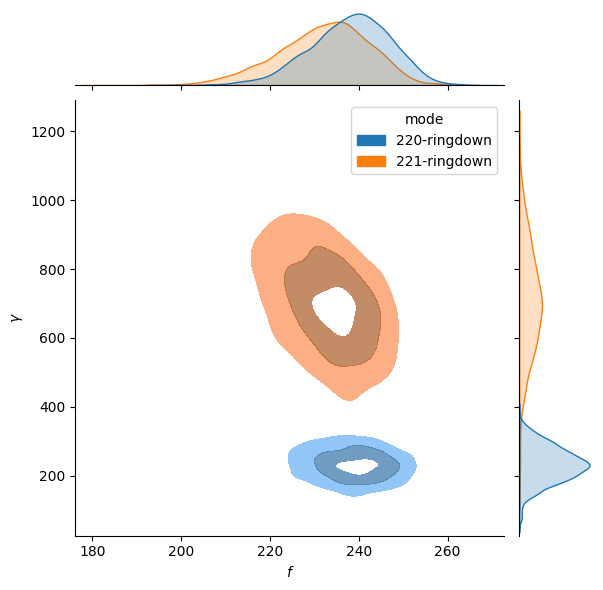

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [66]:
final_posts_f_gamma = final_posts

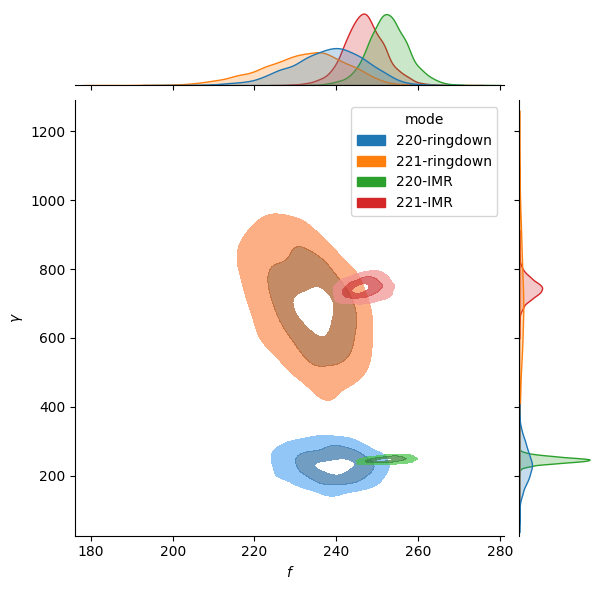

In [65]:
df_plot = pd.concat([df1,final_posts])

g = sns.jointplot(data=df_plot, x=r'$f$', y=r'$\gamma$', hue='mode',
              kind='kde', fill=True, levels=[0.3,0.6,0.9],common_norm=False, alpha=0.7);